# Interacting with the Lepton from Python

If you're new to Jupyter these are the basics. Code is organized into "cells" which are blocks of code that can 
be run one at a time, in any order.
You can execute blocks by highlighting the cell and entering shift+enter or by clicking Run > Run Selected Cells.

Note that a line begining with `!` will be executed in the shell/command prompt of your system. Use the following cell to make
sure you have all of the dependencies of this notebook.

In [ ]:
! python -m pip install pythonnet 
! python -m pip install numpy 
! python -m pip install matplotlib 

## Setup Python's path for the Lepton .NET dlls

Note that because this is a .NET library, it uses .NET naming conventions 
and requires importing `clr` (provided by the `pythonnet` package on pip).

This first cell adds the right version (64 bit vs 32 bit) of the library to 
python's path based on the bit-depth of the python thats currently running. 

In [1]:
import clr # needs the "pythonnet" package
import sys
import os
import time

# check whether python is running as 64bit or 32bit
# to import the right .NET dll
import platform
bits, name = platform.architecture()

if bits == "64bit":
	folder = ["x64"]
else:
	folder = ["x86"]

sys.path.append(os.path.join("..", *folder))

## Import the CCI SDK

In [2]:
# AddReference makes the following `From Lepton ...` line 
# run by hooking the LeptonUVC dll into the python import 
# mechanism
clr.AddReference("LeptonUVC")

from Lepton import CCI

Look for a PureThermal USB device.

In [60]:
found_device = None
for device in CCI.GetDevices():
    if device.Name.startswith("PureThermal"):
        found_device = device
        break

if not found_device:
    print("Couldn't find lepton device")
else:
    lep = found_device.Open()

Get the current camera uptime. This is a good way to test if the 
connection is working.

In [61]:
str(lep.oem.GetSoftwareVersion())

'SwVersion{gpp_major=3, gpp_minor=3, gpp_build=22, dsp_major=3, dsp_minor=3, dsp_build=22, reserved=0}'

In [4]:
lep.sys.GetCameraUpTime()

91457

Run a FFC. If this command executes successfully, the shutter on the lepton should close and open.

In [5]:
lep.sys.RunFFCNormalization()

Get the current palette (**P**seudo-**color** **L**ook **U**p **T**able)

In [59]:
lep.vid.GetPcolorLut()

1

In [56]:
lep.sys.SetGainMode(CCI.Sys.GainMode.LOW)

You can assign the palette with either its index or
its name

In [58]:
lep.vid.SetPcolorLut(1)


The full list of available palettes is:

In [8]:
from System import Enum
list(Enum.GetNames(CCI.Vid.PcolorLut))

['WHEEL6_LUT',
 'FUSION_LUT',
 'RAINBOW_LUT',
 'GLOBOW_LUT',
 'SEPIA_LUT',
 'COLOR_LUT',
 'ICE_FIRE_LUT',
 'RAIN_LUT',
 'USER_LUT']

## Streaming frames from the Lepton

Make sure to keep track of the capture object because creating more than one instance
of it during a single session can cause problems. 

IR16Filters is a library for grabbing Y16 (16 bit greyscale) images from a webcam
because most webcam libraries don't support this format.

numpy is a library for number crunching in python that we can use to hold incomming 
images as 2-dimensional arrays, and matplotlib supports displaying and colorizing 
incomming images.

In [9]:
clr.AddReference("ManagedIR16Filters")
from IR16Filters import IR16Capture, NewIR16FrameEvent, NewBytesFrameEvent

import numpy
from matplotlib import pyplot as plt
# %matplotlib inline is Jupyter magic to display plot results inline in the 
# notebook
%matplotlib inline

capture = None

Start saving incomming images in a queue with a max size so we don't 
use too much memory. Set maxlen higher values to keep more history. 

In [10]:
from collections import deque

# change maxlen to control the number of frames of history we want to keep
incoming_frames = deque(maxlen=10)
def got_a_frame(short_array, width, height):
    incoming_frames.append((height, width, short_array))

if capture != None:
    # don't recreate capture if we already made one
    capture.RunGraph()
else:
    capture = IR16Capture()
    capture.SetupGraphWithBytesCallback(NewBytesFrameEvent(got_a_frame))
    capture.RunGraph()

Skip executing the next cell to keep `incomming_frames`
always stocked with new images

In [11]:
capture.StopGraph()

True

In [11]:
def short_array_to_numpy(height, width, frame):
    return numpy.fromiter(frame, dtype="uint16").reshape(height, width)

Grab the most recent image in the queue (python indexes negative numbers
backwards from the end of arrays) and display it with matplotlib.

If the graph is currently running, this should update the frame everytime you
re-run the following cell. 

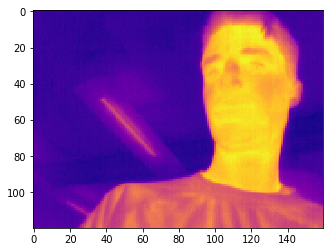

In [12]:
from matplotlib import cm

height, width, net_array = incoming_frames[-1]
arr = short_array_to_numpy(height, width, net_array)

plt.imshow(arr, cmap=cm.plasma)

You can show the image with a variety of different colormaps. This doesn't use the lepton
palette, because we are getting the raw 16-bit image and matplotlib is colorizing it for display purposes. 

`cm.viridis` and `cm.plasma` are both perceptually uniform and should use most of their colorspaces. `cm.bwr` gives a nice hot and cold effect. A full list of avaiable colormaps can be found in 
the matplotlib docs:
[matplotlib.org/examples/color/colormaps_reference.html](https://matplotlib.org/examples/color/colormaps_reference.html)

## Dealing with temperatures

If you are using a Lepton 2.5 or 3.5, radiometry should be enabled. When radiometry is on, 
pixel values are in centikelvin so that they can be represented by unsigned 16 bit integers.
Note that 100cK = 1K. 
Converting to Celcius can be done by dividing by 100 and subtracting absolute zero as shown below.

The following only works if the camera supports tlinear. Use the block 
below to test support.

In [13]:
try:
    lep.rad.SetTLinearEnableStateChecked(True)
    print("this lepton supports tlinear")
except:
    print("this lepton does not support tlinear")

this lepton supports tlinear


In [14]:
height, width, net_array = incoming_frames[-1]
arr = short_array_to_numpy(height, width, net_array)

def centikelvin_to_celsius(t):
    return (t - 27315) / 100

def to_fahrenheit(ck):
    c = centikelvin_to_celsius(ck)
    return c * 9 / 5 + 32

# get the max image temp
print("maximum temp {:.2f} ºF / {:.2f} ºC".format(
    to_fahrenheit(arr.max()), centikelvin_to_celsius(arr.max())))
# get the average image temp
print("average temp {:.2f} ºF / {:.2f} ºC".format(
    to_fahrenheit(arr.mean()), centikelvin_to_celsius(arr.mean())))

maximum temp 88.77 ºF / 31.54 ºC
average temp 72.65 ºF / 22.58 ºC
